In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import io
import string

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from gensim.models import Word2Vec
import numpy as np

# Assuming you have your data in X_train, X_test, y_train, y_test

# Define a function to tokenize the text data and train word embeddings
def tokenize_text(text):
    return text.split()  # You can use a more sophisticated tokenizer if needed

# Step 2: Data Preprocessing and Feature Engineering
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_text, max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Word Embeddings (Word2Vec)
word2vec_model = Word2Vec(sentences=[tokenize_text(text) for text in np.concatenate((X_train, X_test))], 
                          vector_size=100, window=5, min_count=1, workers=4)
word_embeddings = {word: word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key}

# Define a function to compute document embeddings
def compute_doc_embedding(text, word_embeddings):
    tokens = tokenize_text(text)
    embeddings = [word_embeddings[token] for token in tokens if token in word_embeddings]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

X_train_w2v = np.array([compute_doc_embedding(text, word_embeddings) for text in X_train])
X_test_w2v = np.array([compute_doc_embedding(text, word_embeddings) for text in X_test])

# Step 3: Model Training and Hyperparameter Tuning
# Define a pipeline with TF-IDF + SVM classifier
pipeline_tfidf_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC())
])

# Define grid search parameters
param_grid_tfidf_svm = {
    'tfidf__max_features': [5000, 10000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

# Perform grid search
grid_search_tfidf_svm = GridSearchCV(pipeline_tfidf_svm, param_grid_tfidf_svm, cv=5, n_jobs=-1)
grid_search_tfidf_svm.fit(X_train, y_train)

# Step 4: Evaluation
train_score = grid_search_tfidf_svm.score(X_train, y_train)
test_score = grid_search_tfidf_svm.score(X_test, y_test)

print("TF-IDF + SVM Train Score:", train_score)
print("TF-IDF + SVM Test Score:", test_score)

# You can print additional metrics like classification report
y_pred_tfidf_svm = grid_search_tfidf_svm.predict(X_test)
print("TF-IDF + SVM Classification Report:")
print(classification_report(y_test, y_pred_tfidf_svm))


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/emotions/text.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
data = pd.read_csv('/kaggle/input/emotions/text.csv')
data

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [3]:
print("Data Structure:")
print(data.head())

Data Structure:
   Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4


In [3]:
# Convert 'Text' column to lowercase
data['text'] = data['text'].str.lower()
# Remove extra white spaces from the 'text' column
data['text'] = data['text'].str.strip()
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [4]:
from bs4 import BeautifulSoup
import re
def removeTags(text):
    value = BeautifulSoup(text, 'html.parser')
    return value.get_text()

def removeURL(text):
    return re.sub(r'http\S+|www\S+', '', text)

data['text'] = data['text'].apply(removeTags)
data['text'] = data['text'].apply(removeURL)
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
acroList = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}
def changeAcronym(text):
    value = text.split()
    for i, word in enumerate(value):
        if word.lower() in acroList:
            value[i] = acroList[word.lower()]
    return ' '.join(value)

def finalFilter(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data['text'] = data['text'].apply(changeAcronym)
data['text'] = data['text'].apply(finalFilter)
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [17]:
from sklearn.model_selection import train_test_split

subset_size = len(data)  # Adjust this value as needed
X_subset = data['text'][:subset_size]
y_subset = data['label'][:subset_size]

# Split the subset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features for training and testing sets
vectorizer = TfidfVectorizer(max_features=5000)  
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [18]:
def tokenize_text(text):
    return text.split()

In [34]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    
}

# Create XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train_vec, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate model with best parameters
best_xgb_classifier = grid_search.best_estimator_
y_pred = best_xgb_classifier.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with best parameters:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Accuracy with best parameters: 0.8813333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       890
           1       0.89      0.91      0.90       977
           2       0.77      0.75      0.76       244
           3       0.90      0.85      0.87       410
           4       0.83      0.88      0.85       368
           5       0.77      0.69      0.73       111

    accuracy                           0.88      3000
   macro avg       0.85      0.83      0.84      3000
weighted avg       0.88      0.88      0.88      3000

[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  23.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  21.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=  42.6s
[CV

In [35]:
from sklearn.svm import SVC

# Extracting the best parameters from the grid search
best_params_svm = {
    'C': [0.1, 1, 10],  # Example values, replace with your best parameters
    'kernel': ['linear', 'rbf']  # Example values, replace with your best parameters
}

# Create SVM classifier
svm_classifier = SVC()

# Perform grid search
grid_search_svm = GridSearchCV(estimator=svm_classifier, param_grid=best_params_svm, cv=2, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train_vec, y_train)

# Best parameters
best_params_svm = grid_search_svm.best_params_
print("Best Parameters for SVM:", best_params_svm)

# Evaluate model with best parameters
best_svm_classifier = grid_search_svm.best_estimator_
y_pred_svm = best_svm_classifier.predict(X_test_vec)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy with best parameters for SVM:", accuracy_svm)

# Print classification report for SVM
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm))


Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Parameters for SVM: {'C': 1, 'kernel': 'linear'}
Accuracy with best parameters for SVM: 0.8623333333333333
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       890
           1       0.85      0.93      0.89       977
           2       0.84      0.62      0.71       244
           3       0.92      0.79      0.85       410
           4       0.81      0.82      0.82       368
           5       0.78      0.56      0.65       111

    accuracy                           0.86      3000
   macro avg       0.85      0.78      0.81      3000
weighted avg       0.86      0.86      0.86      3000



In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_subset)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max([len(seq) for seq in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='pre')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='pre')

In [20]:
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test), verbose=1)


Epoch 1/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.8433 - loss: 0.3882 - val_accuracy: 0.9394 - val_loss: 0.0961
Epoch 2/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 149s 14ms/step - accuracy: 0.9407 - loss: 0.0999 - val_accuracy: 0.9398 - val_loss: 0.0949
Epoch 3/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 148s 14ms/step - accuracy: 0.9417 - loss: 0.0928 - val_accuracy: 0.9370 - val_loss: 0.1029
Epoch 4/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 149s 14ms/step - accuracy: 0.9420 - loss: 0.0883 - val_accuracy: 0.9373 - val_loss: 0.0912
Epoch 5/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 148s 14ms/step - accuracy: 0.9437 - loss: 0.0851 - val_accuracy: 0.9391 - val_loss: 0.0925
Epoch 6/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 149s 14ms/step - accuracy: 0.9436 - loss: 0.0830 - val_accuracy: 0.9366 - val_loss: 0.0934
Epoch 7/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 148s 14ms/step - accuracy: 0.9445 - loss: 0.0813 - val_accuracy: 0.9361 - val_loss: 0.0960
Epoch 8/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 148s 14ms/s

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


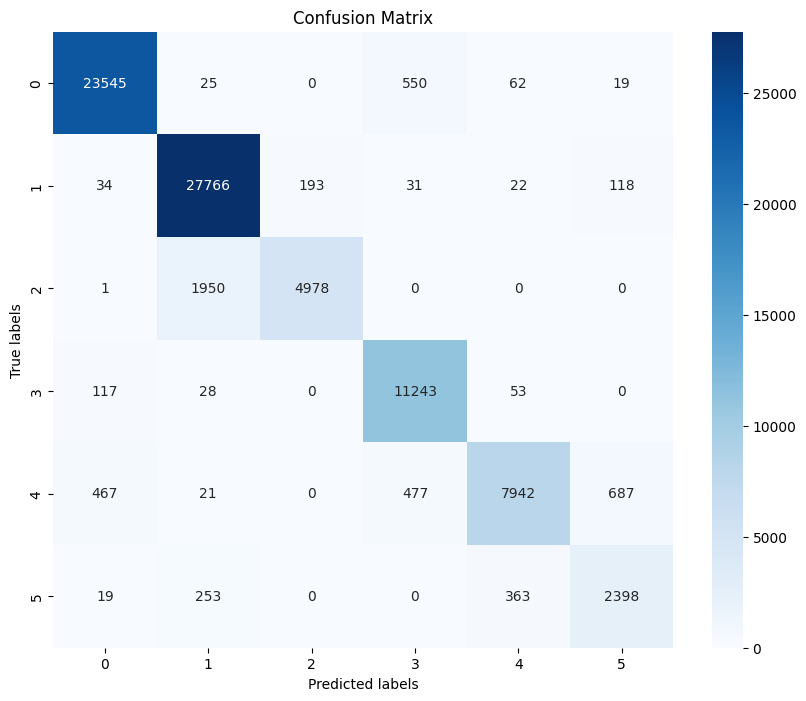

In [29]:
import numpy as np

# Predict probabilities on test data
y_pred_prob = model.predict(X_test_pad)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [30]:
from sklearn.metrics import classification_report

# Predict probabilities on test data
y_pred_prob = model.predict(X_test_pad)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_prob, axis=1)

# Print classification report
print(classification_report(y_test, y_pred))


2606/2606 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     24201
           1       0.92      0.99      0.95     28164
           2       0.96      0.72      0.82      6929
           3       0.91      0.98      0.95     11441
           4       0.94      0.83      0.88      9594
           5       0.74      0.79      0.77      3033

    accuracy                           0.93     83362
   macro avg       0.91      0.88      0.89     83362
weighted avg       0.94      0.93      0.93     83362



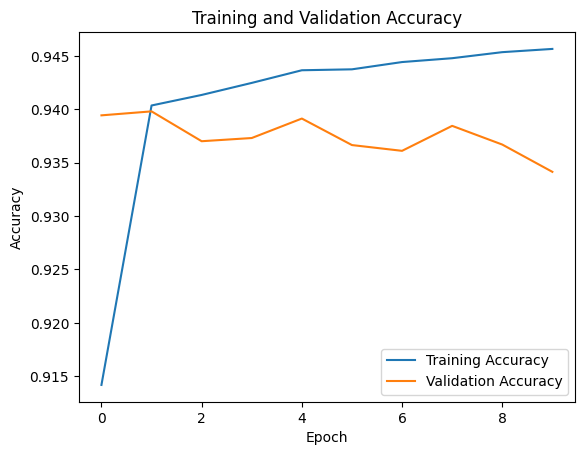

In [31]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
